# 뉴스 요약봇 만들기 [프로젝트]

## 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져본다.

In [1]:
# 주요 라이브러리 버전 확인
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt
from importlib.metadata import version
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.3.3
1.2.0


## 데이터 수집하기

In [2]:
# 아래의 코드로 데이터를 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
df = data.copy()

In [4]:
# data 확인
df.sample(10)

,headlines,text
17707,Aus newspaper reprints 'sexist' Serena cartoon...,An Australian newspaper on Wednesday republish...
17949,I'm okay with harsh comments on my performance...,"Abhishek Bachchan, while talking about critici..."
85716,Amazon CEO Jeff Bezos' net worth drops by $2.6...,Amazon CEO Jeff Bezos lost $2.6 billion and sl...
1681,We want Ram Temple to be constructed by 2025: RSS,Rashtriya Swayamsevak Sangh (RSS) General Secr...
85089,Yuvraj Singh shows 'door opening and closing s...,Indian middle-order batsman Yuvraj Singh showe...
77116,27 lakh businesses yet to complete GST registr...,Over 27 lakh businesses are yet to complete re...
96049,Swiss skier performs world's first 5-rotation ...,Swiss skier Andri Ragettli landed the world's ...
50962,Tell Davos why 1% Indians get 73% of its wealt...,After Prime Minister Narendra Modi addressed t...
78622,Bengaluru Metro Phase 2 to have underground se...,The Phase 2 of Bengaluru Metro's Gottigere-Nag...
58277,China will not export its development model: P...,Chinese President Xi Jinping has said that the...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.   
추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

## 데이터 전처리하기 (추상적 요약)

데이터를 불러왔으니 전처리를 진행해본다.   
- 빈칸으로 존재하는 null 데이터
- 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목
- 같은 학습할 때 방해가 되는 데이터

위 내용을 전처리를 통하여 솎아내보자!

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
# 데이터의 중복 샘플 유/무 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 : ', df['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 : ', df['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 :  98280
text 열에서 중복을 배제한 유일한 샘플의 수 :  98360


중복을 제외한다면 Text에는 98,360개, headlines에는 98,280개의 유니크한 데이터가 존재한다.

데이터프레임의 `drop_duplicates()`를 사용하면, 손쉽게 중복 샘플을 제거할 수 있다.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
df.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(df)))

전체 샘플수 : 98360


중복이 제거되면서 샘플 수가 98,360개로 줄어들었다. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면, `drop_duplicates()`가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있다. 데이터에 Null 값이 남아있는지 확인해본다.

데이터프레임에 Null 값이 있는지 확인하는 방법은 `.isnull().sum()`을 사용하면 확인이 가능하다.

In [7]:
# DataFrame Null 값 확인
print(df.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

98,360개의 샘플에는 수많은 단어들이 있다. 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다.   
기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이다.

이러한 방법론을 텍스트 처리에서는 **텍스트 정규화(text normalization)** 라고 한다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


정규화 준비까지 마쳤으니, 불용어`(stopwords)` 제거를 위한 준비도 해보자!

In [9]:
print("불용어 갯수 :", len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 갯수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 확인할 수 있다.   
이를 사용하여 불용어를 제거한다.

이외에도 영어문자는 소문자로, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리해보자!

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정이다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋을 것 같다. 이 처리를 위해서 함수의 인자로 `remove_stopwords`를 추가하고, `if문`을 추가했다.

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해본다.

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, `<br />`과 같은 html 태그가 제거되었다. `(or finish)`와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 또한 특수문자가 제거되면서 영어만 남았다.

위에서 함수가 잘 실행되는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행한다.   
이때, text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 한다.

In [12]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for i in df['text']:
    clean_text.append(preprocess_sentence(i))
    
# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

이제 headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어준다.

In [13]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

for i in df['headlines']:
    clean_headlines.append(preprocess_sentence(i, False))
    
# 전처리 후 출력
print("text 전처리 후 결과: ", clean_headlines[:5])

text 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 되기 때문이다.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한다. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [14]:
df['text'] = clean_text
df['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
df.replace('', np.nan, inplace=True)

이전과 같이 `.isnull().sum()`을 사용해서 `Null`값이 생겼는지 확인해본다.

In [15]:
df.isnull().sum()

headlines    0
text         0
dtype: int64

위 결과로 확인할 때 Null값은 생기지 않은 것을 확인할 수 있다.   
다시 한번 전체 샘플 수를 확인한다.

In [16]:
print('전체 샘플 수 :', (len(df)))

전체 샘플 수 : 98360


### 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해야 한다.

#### 샘플의 최대 길이 정하기
필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정한다.
text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
머릿말의 최소 길이 : 1
머릿말의 최대 길이 : 16
머릿말의 평균 길이 : 9.299532330215534


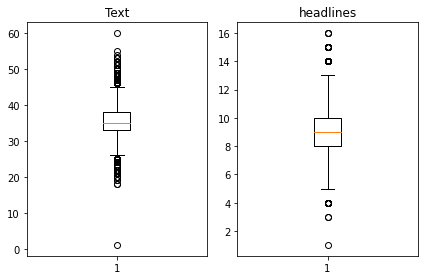

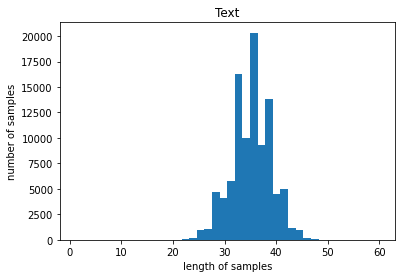

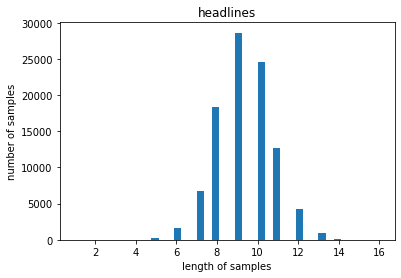

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in df['text']]
headlines_len = [len(s.split()) for s in df['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('머릿말의 최소 길이 : {}'.format(np.min(headlines_len)))
print('머릿말의 최대 길이 : {}'.format(np.max(headlines_len)))
print('머릿말의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 된다. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 머릿말의 길이 분포, 실제 텍스트 샘플 길이별 개수, 머릿말 샘플 길이별 개수를 나타내고 있다.

text의 경우 최소 길이가 1, 최대 길이가 60로 그 차이가 굉장히 크죠. 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있다.

headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 매우 짧다. 그래프로 봤을 때에도 대체적으로 9이하의 길이를 가지고 있다.

이로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해본다.

In [18]:
text_max_len = 40
headlines_max_len = 11

각각 40과 11로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 된다. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보도록 한다.

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.

In [20]:
below_threshold_len(text_max_len, df['text'])
below_threshold_len(headlines_max_len, df['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제해본다.

In [21]:
df = df[df['text'].apply(lambda x: len(x.split()) <= text_max_len)]
df = df[df['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(df)))

전체 샘플수 : 85843


#### 시작 토큰과 종료 토큰 추가하기
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것이다.

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.   
이번 프로젝트에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것이다.   
디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정하였다.   
두 개의 문장 모두 headlines 열로부터 만들것이다.

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df['decoder_input'] = df['headlines'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['headlines'].apply(lambda x : x + ' eostoken')
df.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


앞뒤로 토큰이 잘 붙은것을 확인할 수 있다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해준다.

In [23]:
encoder_input = np.array(df['text']) # 인코더의 입력
decoder_input = np.array(df['decoder_input']) # 디코더의 입력
decoder_target = np.array(df['decoder_target']) # 디코더의 레이블

이제 훈련 데이터와 테스트 데이터를 분리한다.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해본다. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준다.

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[42276 24134 24707 ... 32824 76717 34050]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.

In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해준다. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해준다.

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다. :표시의 위치에 주의할 것.

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


훈련 데이터와 테스트 데이터가 각각 68,675개와 17,168개로 잘 분리된 것을 볼 수 있다.

### 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 **단어 집합(vocabulary)** 을 만든다고 표현한다. 훈련 데이터에 대해서 단어 집합을 만들어본다. 우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장 되어있다. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.

`src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [29]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64694
등장 빈도가 9번 이하인 희귀 단어의 수: 47715
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16979
단어 집합에서 희귀 단어의 비율: 73.75490771941756
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.972441378112387


encoder_input_train에는 6만여 개의 단어가 있다. 그 아래의 통계 정보들을 해석해보자.

등장 빈도가 threshold 값인 10회 미만, 즉 9회 이하인 단어들은 단어 집합에서 무려 73% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.97%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 1만 7천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 17000으로 제한해본다. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [30]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 17,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 현재 단어 집합의 크기를 19,000으로 제한했으니까 이제 19,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[33, 102, 86, 214, 261, 2240, 2616, 11, 1143, 174, 62, 8658, 55, 7, 73, 1673, 11, 1143, 727, 14, 110, 12307, 91, 132, 2693, 1359, 410, 3286, 1816, 77, 2013, 2150, 1580], [124, 1608, 5, 32, 212, 126, 31, 1418, 143, 109, 451, 5924, 107, 354, 567, 1400, 5732, 1829, 349, 2883, 1274, 1482, 124, 100, 1581, 6393, 2784, 4747, 4182, 1987, 1400, 92, 124, 1, 1284, 479, 1484, 6656], [12, 111, 399, 220, 3518, 452, 1588, 405, 55, 18, 51, 449, 4367, 97, 220, 70, 1275, 289, 5860, 188, 8, 3764, 51, 402, 67, 211, 449, 138, 498, 220, 4, 36, 4145, 1609, 3177, 402, 51, 402]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.

headlines 데이터에 대해서도 동일한 작업을 수행한다. 케라스의 토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 `tar_tokenizer.word_index`에 저장되어 있어요. `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.

In [33]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28535
등장 빈도가 7번 이하인 희귀 단어의 수: 20350
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8185
단어 집합에서 희귀 단어의 비율: 71.31592780795513
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.598164124190584


등장 빈도가 7회 이하인 단어들은 단어 집합에서 약 71%를 차지하고 있다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 6.59%밖에 되지 않는다. 아까 했던 것과 동일하게 이 단어들은 모두 제거한다. 어림잡아 8000을 단어 집합의 크기로 제한한다.

In [34]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 20, 62, 1322, 229, 88, 4130, 2153, 4, 5674], [1, 151, 1116, 4, 15, 5, 3227, 7, 137, 788, 960], [1, 101, 1205, 5399, 3, 405, 1648, 527, 6, 135, 110], [1, 379, 5, 426, 1945, 803, 289], [1, 7599, 2457, 970, 464, 26, 21, 2340, 1409, 860]]
target
decoder  [[20, 62, 1322, 229, 88, 4130, 2153, 4, 5674, 2], [151, 1116, 4, 15, 5, 3227, 7, 137, 788, 960, 2], [101, 1205, 5399, 3, 405, 1648, 527, 6, 135, 110, 2], [379, 5, 426, 1945, 803, 289, 2], [7599, 2457, 970, 464, 26, 21, 2340, 1409, 860, 2]]


정상적으로 정수 인코딩 작업이 끝났다. 현재 `decoder_input_train`과 `decoder_target_train`에는 더 이상 숫자 8,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 머릿말(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와본다. 여기서 주의할 점은 요약문인 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것이다. 길이 0이 된 `ecoder_input`에는 `sostoken`, `decoder_target`에는 `eostoken`만 남아 있을 것이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장해본다. 이 샘플들은 모두 삭제한다.

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있다.

#### 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 한다. 아까 정해두었던 최대 길이로 패딩 해 줄 것이다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다.

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

이제 학습에 필요한 데이터 전처리가 모두 끝났다.

### 모델 설계하기
우선 함수형 API를 이용해서 인코더를 설계해본다.

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

이제 디코더를 설계해본다. (어텐션 메커니즘을 적용하여)

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 64s 86ms/step - loss: 5.9932 - val_loss: 5.6006
Epoch 2/50
269/269 [==============================] - 22s 83ms/step - loss: 5.5273 - val_loss: 5.3279
Epoch 3/50
269/269 [==============================] - 23s 86ms/step - loss: 5.1537 - val_loss: 4.9093
Epoch 4/50
269/269 [==============================] - 23s 86ms/step - loss: 4.7249 - val_loss: 4.5909
Epoch 5/50
269/269 [==============================] - 23s 85ms/step - loss: 4.3943 - val_loss: 4.3606
Epoch 6/50
269/269 [==============================] - 23s 85ms/step - loss: 4.1314 - val_loss: 4.1979
Epoch 7/50
269/269 [==============================] - 23s 86ms/step - loss: 3.9103 - val_loss: 4.0710
Epoch 8/50
269/269 [==============================] - 23s 86ms/step - loss: 3.7196 - val_loss: 3.9720
Epoch 9/50
269/269 [==============================] - 23s 85ms/step - loss: 3.5530 - val_loss: 3.9006
Epoch 10/50
269/269 [==============================] - 23s 86ms/step - loss: 3.406

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해본다.

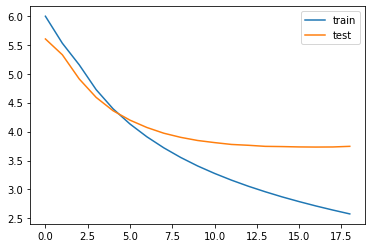

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해둔다.

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비한다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 메커니즘을 사용하는 출력층을 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만든다

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어본다. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 머릿말의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [45]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : iran bears resemblance barcelona forward lionel messi car taken police station disrupting traffic iranian city pressured father posing messi jersey landed modelling contracts due resemblance argentine 
실제 요약 : police messi lookalike car for traffic 
예측 요약 :  neymar builds messi mural of him


원문 : north korea saturday test fired three short range missiles sea japan us said however three missiles failed one blowing almost immediately launch two failing flight comes amid us south korea ongoing joint military drills north korea denounced preparation war 
실제 요약 : north korea test launches three missiles all of them fail 
예측 요약 :  korea tests missile test with ballistic missile


원문 : lawsuit car delivery service claimed uber may saving million year using price rides market rates california drivers independent contractors suit alleged uber paying average hour expenses benefits drivers treated employees 
실제 요약 : uber accused of saving mn year by cheating us drivers 
예측 요약 :  uber fires 

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보인다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과이다!

## 추출적 요약 해보기

텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있다.

### summarize 사용하기

In [46]:
import requests
from summa.summarizer import summarize

In [57]:
df_2 = data.copy()

In [67]:
for idx, text in enumerate(df_2['text'][:3]):
    print(f'원문_{idx+1} \n{text}')
    summary = summarize(text, ratio=0.5, split=True)
    print(f'요약 \n{" ".join(summary)}\n') # 요약된 문장들을 합쳐서 출력합니다.

원문_1 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
요약 
upGrad's Online Power Learning has powered 3 lakh+ careers.

원문_2 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
요약 
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

원문_3 
New Zealand defeated India by 8 wickets 